# DEEP LEARNING BASED TIRE WEAR PREDICTION

## Importing and setup

In [ ]:
!pip install pandas opencv-python matplotlib seaborn

In [ ]:
!pip install scikit-learn shap opencv-python

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import math
import copy
import cv2


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
from skimage import io
from PIL import Image

##Function Definition

In [ ]:
 def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(50)

## Data Splitting

In [ ]:
drive.mount('/content/drive')

dataset_dir = "/content/drive/My Drive/newModelData2"
train_dir = "/content/drive/My Drive/newModelData2/Train"
test_dir = "/content/drive/My Drive/newModelData2/Test/"
val_dir = "/content/drive/My Drive/newModelData2/Validation/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_names = [
    "Alignment Issue", "Inflation Problem",
]

In [ ]:
drive.mount('/content/drive')

# Define full directory paths
dataset_dir = "/content/drive/MyDrive/newModelData2"
train_dir = "/content/drive/MyDrive/newModelData2/Train"
test_dir = "/content/drive/MyDrive/newModelData2/Test/"
val_dir = "/content/drive/MyDrive/newModelData2/Validation/"

folder_names = [
    "Alignment Issue", "Inflation Problem",
]

for i, folder_name in enumerate(folder_names):
    old_folder_path = os.path.join(dataset_dir, folder_name)
    new_folder_name = str(i)
    new_folder_path = os.path.join(dataset_dir, new_folder_name)

    if os.path.exists(old_folder_path):
        os.rename(old_folder_path, new_folder_path)
        print(f"Renamed '{folder_name}' to '{new_folder_name}'")
    else:
        print(f"Warning: '{folder_name}' directory does not exist in {dataset_dir}")

print("Folder renaming completed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder renaming completed.


In [ ]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
folder_names = [
    "0", "1",
]

In [ ]:
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

for folder_name in folder_names:
    folder_path = os.path.join(dataset_dir, folder_name)
    images = os.listdir(folder_path)
    random.shuffle(images)

    total_images = len(images)
    train_count = int(total_images * train_ratio)
    test_count = int(total_images * test_ratio)
    val_count = total_images - train_count - test_count

    train_images = images[:train_count]
    test_images = images[train_count:train_count + test_count]
    val_images = images[train_count + test_count:]

    for image_name in train_images:
        src_path = os.path.join(folder_path, image_name)
        dst_path = os.path.join(train_dir, folder_name, image_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image_name in test_images:
        src_path = os.path.join(folder_path, image_name)
        dst_path = os.path.join(test_dir, folder_name, image_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image_name in val_images:
        src_path = os.path.join(folder_path, image_name)
        dst_path = os.path.join(val_dir, folder_name, image_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

print("Dataset splitting completed.")

Dataset splitting completed.


## Data analysis



In [ ]:
train_dir = "/content/drive/MyDrive/newModelData2/Train/"
test_dir = "/content/drive/MyDrive/newModelData2/Test/"
validation_dir ="/content/drive/MyDrive/newModelData2/Validation/"

In [ ]:
train_data = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        train_data.append((file_path, class_name))

In [ ]:
train_df = pd.DataFrame(train_data, columns=['File_Path', 'Class_Name'])
train_df

File_Path Class_Name
0    /content/drive/MyDrive/newModelData2/Train/0/9...          0
1    /content/drive/MyDrive/newModelData2/Train/0/8...          0
2    /content/drive/MyDrive/newModelData2/Train/0/0...          0
3    /content/drive/MyDrive/newModelData2/Train/0/a...          0
4    /content/drive/MyDrive/newModelData2/Train/0/a...          0
..                                                 ...        ...
514  /content/drive/MyDrive/newModelData2/Train/1/a...          1
515  /content/drive/MyDrive/newModelData2/Train/1/C...          1
516  /content/drive/MyDrive/newModelData2/Train/1/a...          1
517  /content/drive/MyDrive/newModelData2/Train/1/a...          1
518  /content/drive/MyDrive/newModelData2/Train/1/a...          1

[519 rows x 2 columns]

In [ ]:
class_counts = train_df['Class_Name'].value_counts().sort_index()
train_df['Class_Name'].value_counts().sort_index()

Class_Name
0    263
1    256
Name: count, dtype: int64

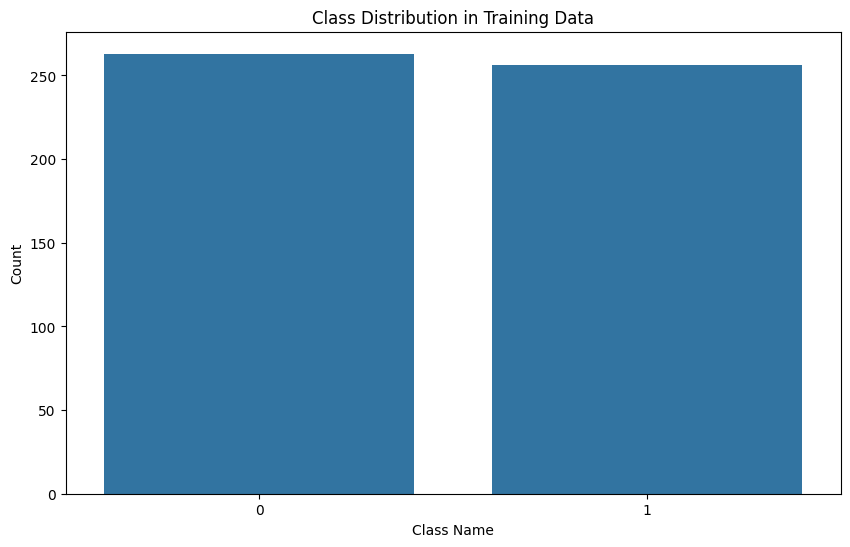

In [ ]:
# Visualize the class distribution using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')
plt.show()

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomZoom(0.2),
#   tf.keras.layers.RandomHeight(0.2),
#   tf.keras.layers.RandomWidth(0.2),
# ])

          total_image
Category             
0                 263
1                 256


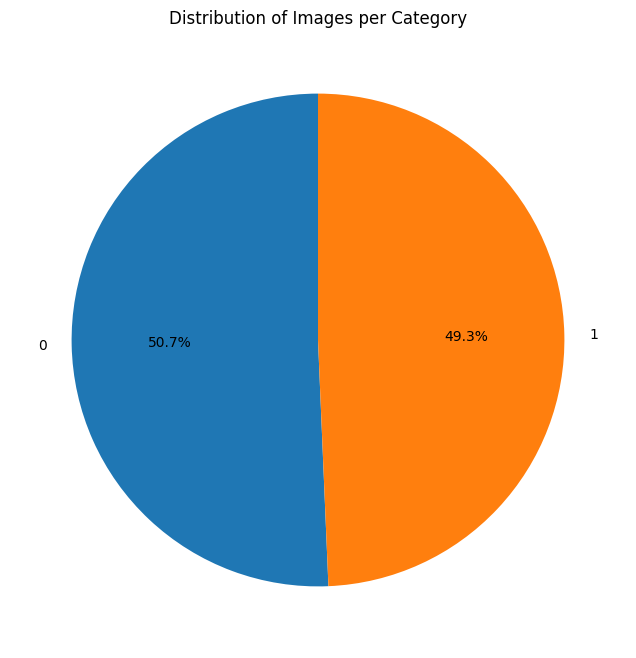

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory for training data
train_dir = "/content/drive/MyDrive/newModelData2/Train/"

# Initialize a list to hold category names and counts
category_counts = []

# Traverse through each category folder in the training directory
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        # Count the number of files in each category folder
        count = len([file for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))])
        category_counts.append((category, count))

# Convert the list of category counts to a DataFrame for better visualization
crop_df = pd.DataFrame(category_counts, columns=['Category', 'total_image'])
crop_df.set_index('Category', inplace=True)

# Display the DataFrame
print(crop_df)

# Visualize the data as a pie chart
plt.figure(figsize=(8, 8))
crop_df['total_image'].plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Distribution of Images per Category')
plt.show()

In [ ]:
img_width, img_height = 299, 299

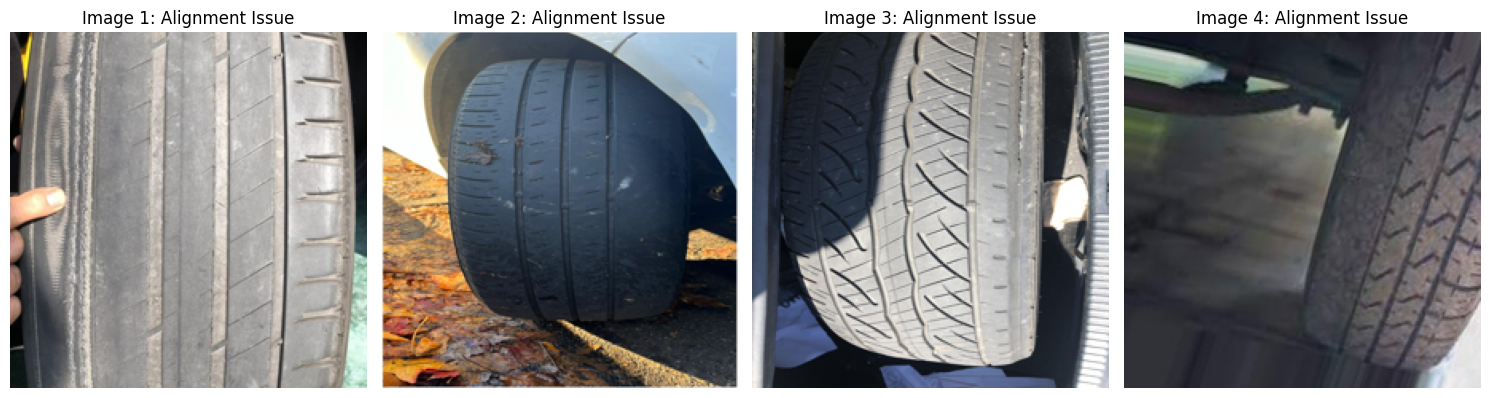

In [ ]:
# Assuming train_df is your DataFrame
desired_class = "0"
name = "Alignment Issue"

desired_class_df = train_df[train_df['Class_Name'] == desired_class]

num_images_to_plot = 4
img_width, img_height = 224, 224  # Ensure these are defined

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for i, (index, row) in enumerate(desired_class_df.head(num_images_to_plot).iterrows()):
    image_path = row['File_Path']
    image = Image.open(image_path).resize((img_width, img_height))

    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Model

## Xception - Model 1

In [ ]:
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [ ]:
model1 = Xception(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
input_shape = (299, 299, 3)
batch_size = 16

datagen_train = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    shear_range=0.3,
)

datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

generator_train = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

generator_val = datagen_val.flow_from_directory(
    directory=val_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

generator_test = datagen_test.flow_from_directory(
    directory=test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 519 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

i=0
for batch in datagen.flow_from_directory(directory="/content/drive/MyDrive/newModelData2/0",
                                         batch_size=16,
                                         target_size=(299,299),
                                         color_mode="rgb",
                                         save_to_dir="/content/drive/MyDrive/newModelData2/0",
                                         save_prefix='aug',
                                         save_format='jpg'):
    i+=1
    if i>15:
        break

j=0
for batch in datagen.flow_from_directory(directory="/content/drive/MyDrive/newModelData2/1",
                                         batch_size=16,
                                         target_size=(299,299),
                                         color_mode="rgb",
                                         save_to_dir="/content/drive/MyDrive/newModelData2/1",
                                         save_prefix='aug',
                                         save_format='jpg'):
    j+=1
    if j>16:
        break

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
math.ceil(generator_train.samples)

519

In [ ]:
next(generator_train)[1]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
conv_model = Model(inputs=model1.input, outputs=model1.output)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class DualAttention(Layer):
    def __init__(self, input_dim, **kwargs):
        super(DualAttention, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.query = Dense(input_dim)
        self.key = Dense(input_dim)
        self.value = Dense(input_dim)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value)

        return attention_output


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2

# Load the base model
conv_model = Xception(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

# Define the model architecture with DualAttention
model = Sequential()
model.add(conv_model)
model.add(DualAttention(input_dim=conv_model.output.shape[-1], name='dual_attention_layer'))  # Add DualAttention layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5, name='output_layer2'))
model.add(Dense(2, activation='softmax', name='output_layer1'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dual_attention_layer (Dual  (None, 10, 10, 2048)      12589056  
 Attention)                                                      
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dropout (Dropout)           (None, 204800)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               104858112 
                                                                 
 output_layer2 (Dropout)     (None, 512)               0         
                                                        

In [ ]:
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

# model = Sequential()
# model.add(conv_model)
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.5, name='output_layer2'))
# model.add(Dense(2, activation='softmax', name='output_layer1'))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dual_attention_layer (Dual  (None, 10, 10, 2048)      12589056  
 Attention)                                                      
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dropout (Dropout)           (None, 204800)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               104858112 
                                                                 
 output_layer2 (Dropout)     (None, 512)               0         
                                                        

In [ ]:
num_iters = 300
num_batches_train = generator_train.n // batch_size
epochs = int(num_iters / num_batches_train)

steps_per_epoch = generator_train.n // batch_size
validation_steps = generator_val.n // batch_size


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/newModelData2/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
steps_per_epoch = math.ceil(generator_train.samples / batch_size)
validation_steps = math.ceil(generator_val.samples / batch_size)

Checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'Xception_model_epoch_{epoch:02d}.hdf5'),
    monitor="val_accuracy",
    save_best_only=False,
    save_weights_only=False,
    mode="auto"
)

EarlyStop = EarlyStopping(
    monitor="accuracy",
    patience=5,
    restore_best_weights=True,
    mode="auto"
)

# Train the model
epochs = 30  # Define the number of epochs
history = model.fit(
    generator_train,
    epochs=epochs,
    callbacks=[Checkpoint, EarlyStop],
    steps_per_epoch=steps_per_epoch,
    validation_data=generator_val,
    validation_steps=validation_steps
)

Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 9.6878 - accuracy: 0.5511

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 58s 762ms/step - loss: 9.6878 - accuracy: 0.5511 - val_loss: 8.4130 - val_accuracy: 0.6000
Epoch 2/30
33/33 [==============================] - 20s 609ms/step - loss: 7.4110 - accuracy: 0.6050 - val_loss: 6.5816 - val_accuracy: 0.6667
Epoch 3/30
33/33 [==============================] - 21s 638ms/step - loss: 5.9381 - accuracy: 0.6686 - val_loss: 5.5656 - val_accuracy: 0.5867
Epoch 4/30
33/33 [==============================] - 22s 605ms/step - loss: 4.9570 - accuracy: 0.6435 - val_loss: 4.5909 - val_accuracy: 0.6533
Epoch 5/30
33/33 [==============================] - 22s 606ms/step - loss: 4.1690 - accuracy: 0.7283 - val_loss: 4.0927 - val_accuracy: 0.6400
Epoch 6/30
33/33 [==============================] - 22s 673ms/step - loss: 3.5875 - accuracy: 0.7380 - val_loss: 3.5060 - val_accuracy: 0.7200
Epoch 7/30
33/33 [==============================] - 21s 645ms/step - loss: 3.1315 - accuracy: 0.7572 - val_loss: 2.8438 - val_accuracy: 0.8267
Epoch 8/30

In [ ]:
model.save('/content/drive/MyDrive/newModelData2/checkpoints/final_model.h5')

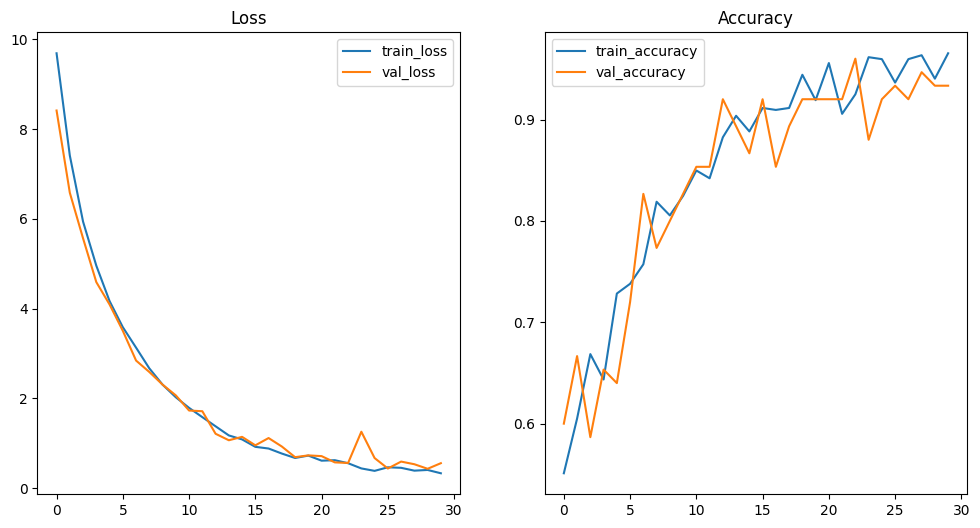

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/newModelData2/checkpoints/final_model.h5"

In [ ]:
from tensorflow.keras.models import load_model

# Load the model with the custom layer
# model_path = "/content/drive/MyDrive/newModelData2/checkpoints/final_model_with_attention.h5"
new_model = load_model(model_path, custom_objects={'DualAttention': DualAttention})

In [ ]:
Y_pred = new_model.predict(generator_test)
y_pred = np.argmax(Y_pred, axis=1)

10/10 [==============================] - 32s 3s/step


In [ ]:
class_labels = list(generator_test.class_indices.keys())

In [ ]:
print(classification_report(generator_test.classes, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        75
           1       0.97      0.90      0.94        73

    accuracy                           0.94       148
   macro avg       0.94      0.94      0.94       148
weighted avg       0.94      0.94      0.94       148



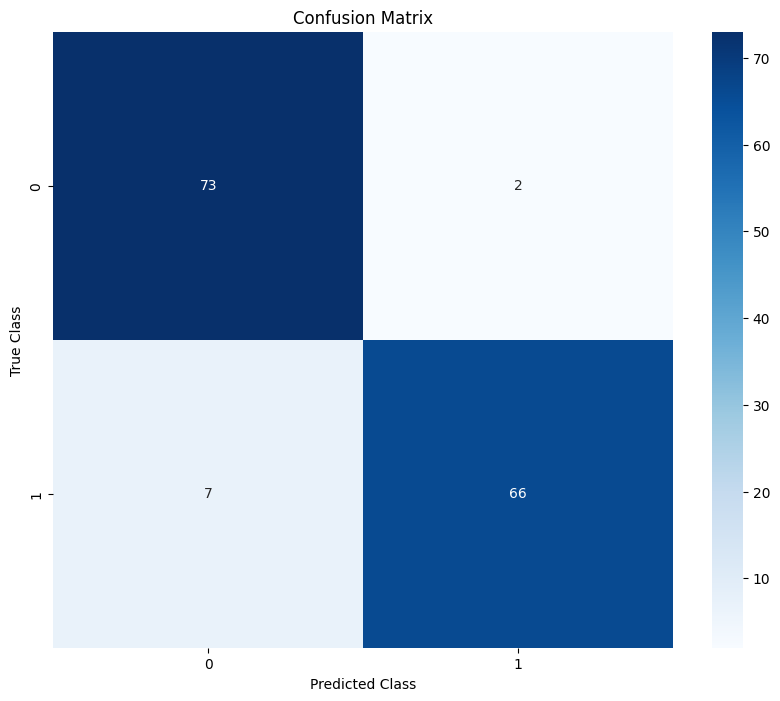

In [ ]:
cm = confusion_matrix(generator_test.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
image_path_show_X=[]
image_show_X=[]

class_image_path_show_X=[]
class_image_show_X=[]

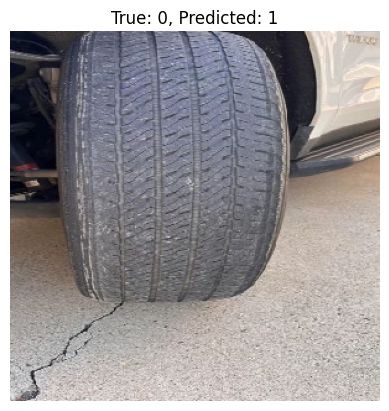

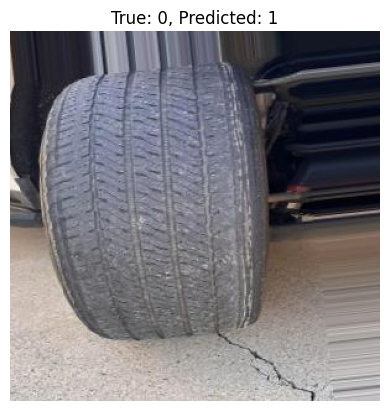

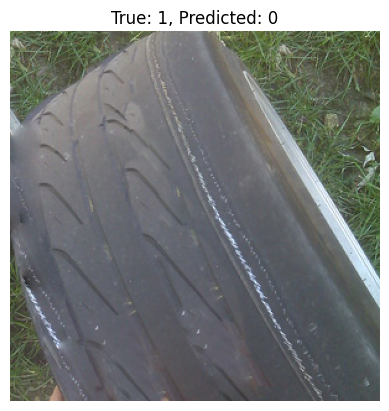

In [ ]:
img_width, img_height= 299, 299
misclassified_images_X = []
for i in range(len(y_pred)):
    if y_pred[i] != generator_test.classes[i]:
        img_path = generator_test.filepaths[i]
        true_label = generator_test.classes[i]
        predicted_label = y_pred[i]
        misclassified_images_X.append((img_path, true_label, predicted_label))


num_display = 3
for img_path, true_label, predicted_label in misclassified_images_X[:num_display]:
    img = load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()

    image_path_show_X.append(img_path)
    image_show_X.append(img)

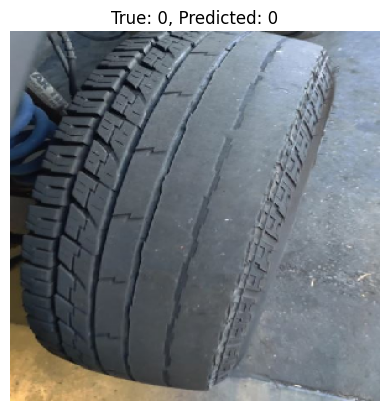

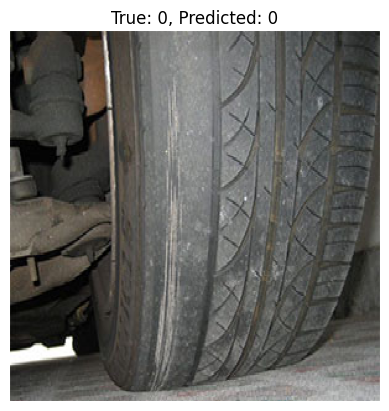

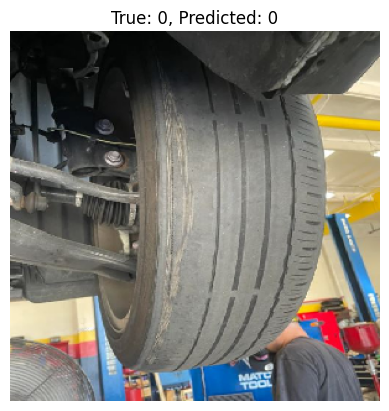

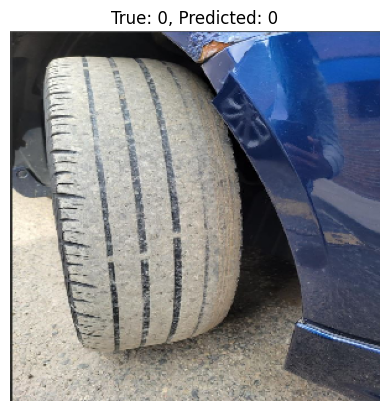

In [ ]:
img_width, img_height= 299, 299
classified_images_X = []
for i in range(len(y_pred)):
    if y_pred[i] == generator_test.classes[i]:
        img_path = generator_test.filepaths[i]
        true_label = generator_test.classes[i]
        predicted_label = y_pred[i]
        classified_images_X.append((img_path, true_label, predicted_label))


num_display = 4
for img_path, true_label, predicted_label in classified_images_X[:num_display]:
    img = load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()

    class_image_path_show_X.append(img_path)
    class_image_show_X.append(img)

## Fine Tune

In [ ]:
model.layers[0].trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs

ReduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)

history_fine = model.fit(
    generator_train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[Checkpoint, EarlyStop, ReduceLR],
    steps_per_epoch=steps_per_epoch,
    validation_data=generator_val,
    validation_steps=validation_steps
)

Epoch 30/50
33/33 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.9672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 56s 1s/step - loss: 0.3629 - accuracy: 0.9672 - val_loss: 0.5401 - val_accuracy: 0.9333 - lr: 1.0000e-06
Epoch 31/50
33/33 [==============================] - 22s 658ms/step - loss: 0.3211 - accuracy: 0.9576 - val_loss: 0.5340 - val_accuracy: 0.9200 - lr: 1.0000e-06
Epoch 32/50
33/33 [==============================] - 20s 613ms/step - loss: 0.3272 - accuracy: 0.9595 - val_loss: 0.5351 - val_accuracy: 0.9200 - lr: 1.0000e-06
Epoch 33/50
33/33 [==============================] - 21s 641ms/step - loss: 0.3066 - accuracy: 0.9672 - val_loss: 0.5259 - val_accuracy: 0.9200 - lr: 1.0000e-06
Epoch 34/50
33/33 [==============================] - 22s 624ms/step - loss: 0.3058 - accuracy: 0.9576 - val_loss: 0.5191 - val_accuracy: 0.9200 - lr: 1.0000e-06
Epoch 35/50
33/33 [==============================] - 25s 703ms/step - loss: 0.3642 - accuracy: 0.9538 - val_loss: 0.5135 - val_accuracy: 0.9333 - lr: 1.0000e-06


In [ ]:
history.history.update(history_fine.history)

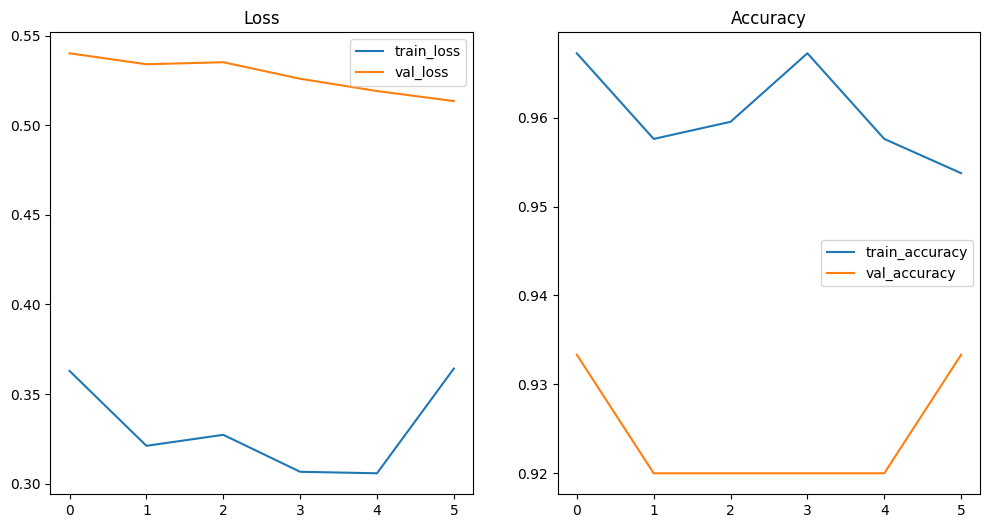

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [ ]:
model_save_path = "/content/drive/MyDrive/newModelData2/checkpoints/Xception_fine_tuned_model.h5"
model.save(model_save_path)

## Using Grad-CAM for Model Explainability

In [ ]:
model_path = "/content/drive/MyDrive/newModelData2/checkpoints/final_model.h5"

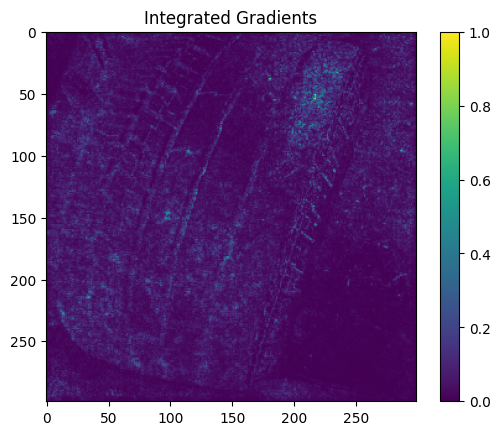

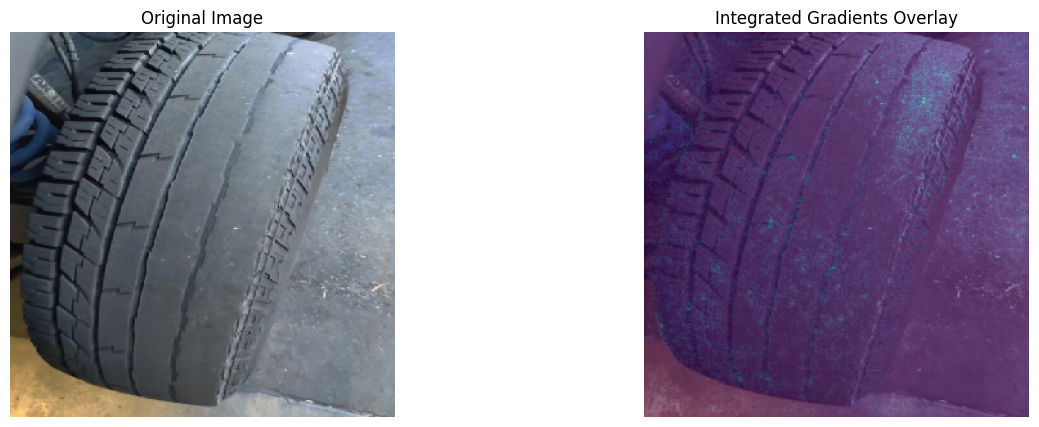

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the model with the custom layer
# model_path = "/content/drive/MyDrive/newModelData2/checkpoints/final_model_with_attention.h5"
new_model = load_model(model_path, custom_objects={"DualAttention": DualAttention})

# Define a function to compute gradients
@tf.function
def compute_gradients(inputs, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    return tape.gradient(predictions, inputs)

# Define a function for Integrated Gradients
def integrated_gradients(inputs, model, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(inputs)
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    gradients = [compute_gradients(x, model) for x in scaled_inputs]
    avg_gradients = tf.reduce_mean(tf.stack(gradients), axis=0)
    integrated_grads = (inputs - baseline) * avg_gradients
    return integrated_grads

# Select an image for explanation
img_path = '/content/drive/MyDrive/newModelData2/Test/0/1600755.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)  # Ensure the image is preprocessed correctly

# Compute Integrated Gradients
integrated_grads = integrated_gradients(img, new_model)

# Normalize the Integrated Gradients for visualization
integrated_grads = tf.reduce_sum(tf.abs(integrated_grads), axis=-1).numpy()
integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min())

# Visualize the results
plt.imshow(integrated_grads[0], cmap='viridis')
plt.colorbar()
plt.title('Integrated Gradients')
plt.show()

# Overlay the gradients on the original image
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image.array_to_img(img[0]))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(image.array_to_img(img[0]))
ax[1].imshow(integrated_grads[0], cmap='viridis', alpha=0.6)
ax[1].set_title('Integrated Gradients Overlay')
ax[1].axis('off')

plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

In [ ]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

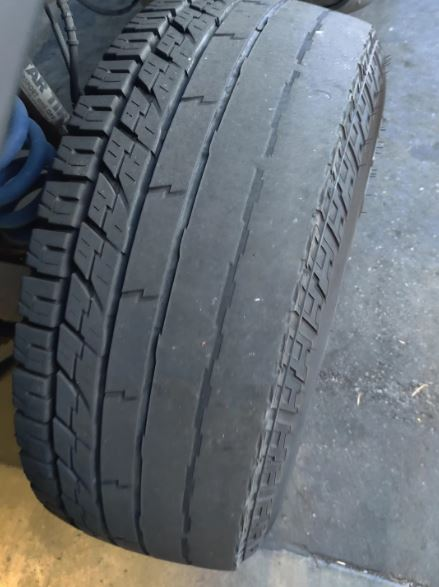

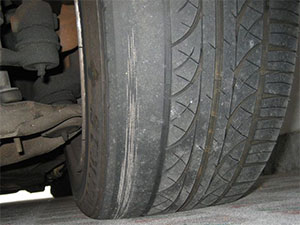

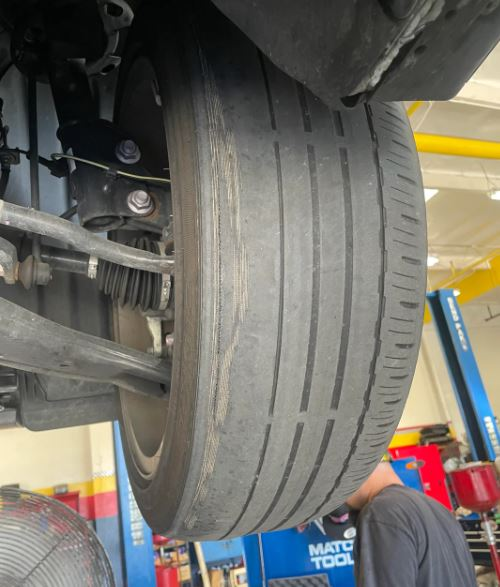

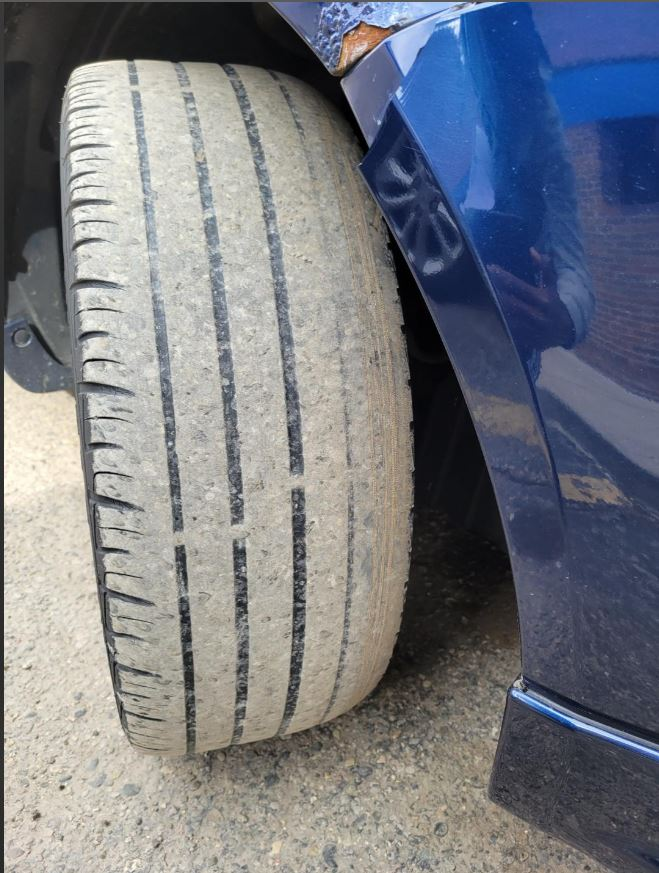

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Assuming class_image_path_show_X is a list of image paths
for path in class_image_path_show_X:
    img_path = path
    img = Image.open(img_path)
    display(img)

In [ ]:
heatmapsX=[]

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02974003', 'car_wheel', 10.969566)]


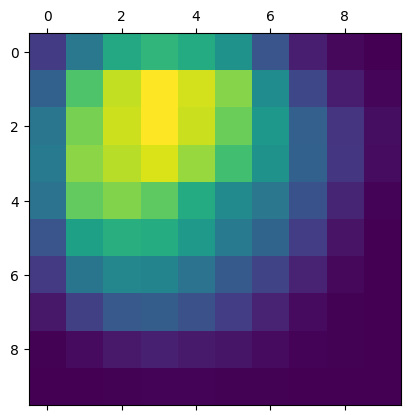

1/1 [==============================] - 1s 749ms/step
Predicted: [('n02974003', 'car_wheel', 9.556224)]


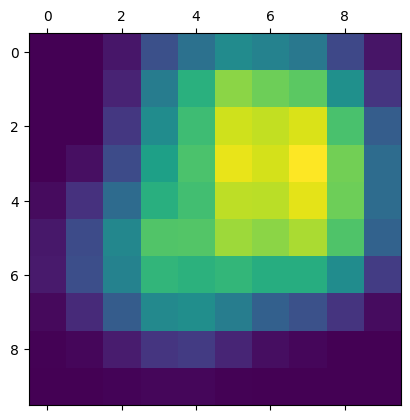

1/1 [==============================] - 1s 747ms/step
Predicted: [('n03208938', 'disk_brake', 8.432761)]


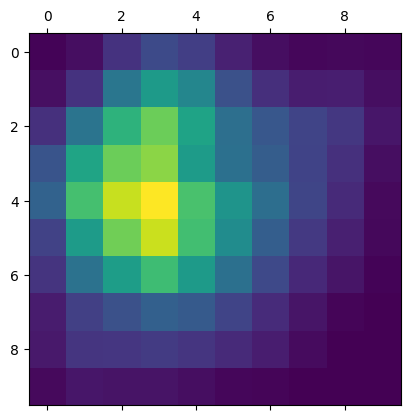

1/1 [==============================] - 1s 753ms/step
Predicted: [('n02795169', 'barrel', 8.354755)]


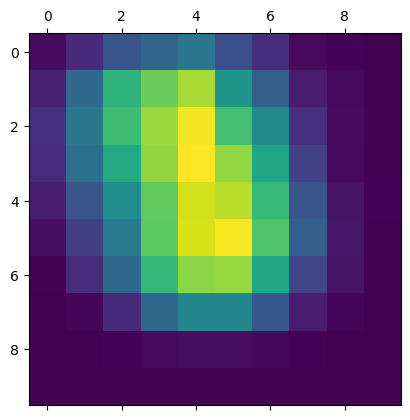

In [ ]:
for img_path in class_image_path_show_X:
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None

    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmapsX.append(heatmap)

    plt.matshow(heatmap)
    plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))


for i in range(len(class_image_path_show_X)):
    img_path= class_image_path_show_X[i]
    heatmap= heatmapsX[i]
    save_and_display_gradcam(img_path, heatmap)

<ipython-input-58-4ae427bdbb36>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


TypeError: 'module' object is not callable

new

## MobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
base_model2 = MobileNetV2(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

In [ ]:
input_shape = (299, 299)
batch_size = 16

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20
)

datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

generator_train = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

generator_val = datagen_val.flow_from_directory(
    directory=val_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

generator_test = datagen_test.flow_from_directory(
    directory=test_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 519 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
steps_per_epoch = math.ceil(generator_train.samples / batch_size)
validation_steps = math.ceil(generator_val.samples / batch_size)

In [ ]:
conv_model2 = Model(inputs=base_model2.input, outputs=base_model2.output)

In [ ]:
math.ceil(generator_train.samples)


519

In [ ]:
next(generator_train)[1]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class DualAttention(Layer):
    def __init__(self, input_dim, **kwargs):
        super(DualAttention, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.query = Dense(input_dim)
        self.key = Dense(input_dim)
        self.value = Dense(input_dim)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value)

        return attention_output


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(conv_model2)
model.add(DualAttention(input_dim=conv_model.output.shape[-1], name='dual_attention_layer'))  # Add DualAttention layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


In [ ]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 10, 10, 1280)      2257984   
                                                                 
 dual_attention_layer (Dual  (None, 10, 10, 1024)      3935232   
 Attention)                                                      
                                                                 
 flatten_4 (Flatten)         (None, 102400)            0         
                                                                 
 dropout_7 (Dropout)         (None, 102400)            0         
                                                                 
 dense_29 (Dense)            (None, 512)               52429312  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
# num_iters = 30000
# num_batches_train = generator_train1.n // batch_size

# epochs = int(num_iters / num_batches_train)
# print("Epoch: ",epochs)
# desired_train_accuracy = 0.99

# steps_per_epoch = generator_train1.n // batch_size
# steps_val = generator_val1.n // batch_size
# print("Steps_per_epoch: ",steps_per_epoch)
# print("Steps_val: ",steps_val)

In [ ]:
# Define ModelCheckpoint and EarlyStopping callbacks
checkpoint_dir = "/content/drive/MyDrive/newModelData2/checkpoints_MobileNetV2"
os.makedirs(checkpoint_dir, exist_ok=True)

steps_per_epoch = math.ceil(generator_train.samples / generator_train.batch_size)
validation_steps = math.ceil(generator_val.samples / generator_val.batch_size)


Checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'MobileNetV2_model_epoch_{epoch:02d}.hdf5'),
    monitor="val_accuracy",
    save_best_only=False,
    save_weights_only=False,
    mode="auto"
)

EarlyStop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="auto"
)

# Train the model
epochs = 30  # Define the number of epochs
history = model.fit(
    generator_train,
    epochs=epochs,
    callbacks=[Checkpoint, EarlyStop],
    steps_per_epoch=steps_per_epoch,
    validation_data=generator_val,
    validation_steps=validation_steps
)

Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 12.0768 - accuracy: 0.5222

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 53s 829ms/step - loss: 12.0768 - accuracy: 0.5222 - val_loss: 11.0962 - val_accuracy: 0.5600
Epoch 2/30
33/33 [==============================] - 27s 844ms/step - loss: 10.9454 - accuracy: 0.5857 - val_loss: 10.8580 - val_accuracy: 0.5333
Epoch 3/30
33/33 [==============================] - 27s 827ms/step - loss: 10.4672 - accuracy: 0.6031 - val_loss: 10.1499 - val_accuracy: 0.5467
Epoch 4/30
33/33 [==============================] - 28s 850ms/step - loss: 10.0366 - accuracy: 0.6012 - val_loss: 9.9298 - val_accuracy: 0.5733
Epoch 5/30
33/33 [==============================] - 28s 857ms/step - loss: 9.5967 - accuracy: 0.6050 - val_loss: 9.4279 - val_accuracy: 0.5733
Epoch 6/30
33/33 [==============================] - 29s 848ms/step - loss: 9.1883 - accuracy: 0.6898 - val_loss: 9.1321 - val_accuracy: 0.5733
Epoch 7/30
33/33 [==============================] - 30s 871ms/step - loss: 8.9871 - accuracy: 0.6416 - val_loss: 8.8449 - val_accuracy: 0.6267
Epo

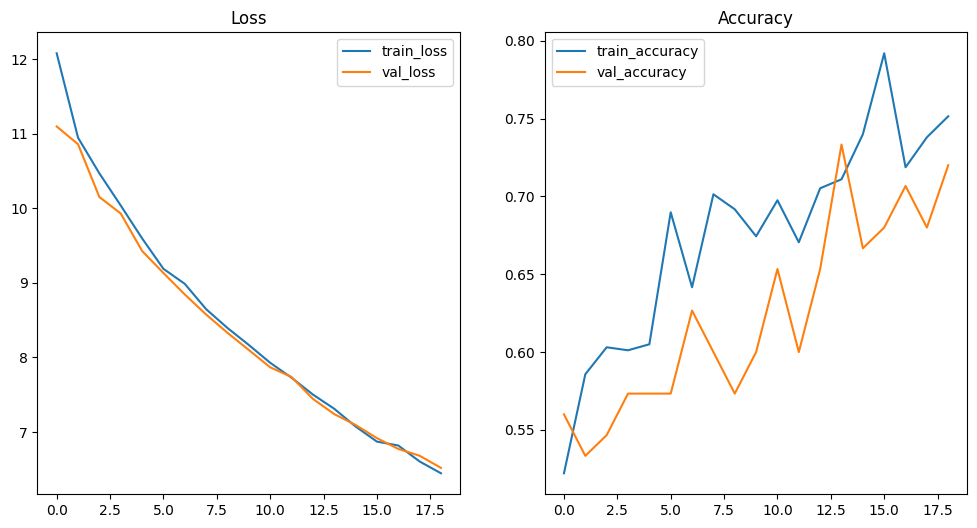

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/newModelData2/checkpoints_MobileNetV2/final_mobilenet_model.h5')

In [ ]:
model_path = "/content/drive/MyDrive/newModelData2/checkpoints_MobileNetV2/final_mobilenet_model.h5"

In [ ]:
# new_model=tf.keras.models.load_model(model_path)
from tensorflow.keras.models import load_model

# Load the model with the custom layer
# model_path = "/content/drive/MyDrive/newModelData2/checkpoints/final_model_with_attention.h5"
new_model = load_model(model_path, custom_objects={'DualAttention': DualAttention})

In [ ]:
Y_pred = new_model.predict(generator_test)
y_pred = np.argmax(Y_pred, axis=1)

10/10 [==============================] - 2s 107ms/step


In [ ]:
class_labels = list(generator_test.class_indices.keys())

In [ ]:
print(classification_report(generator_test.classes, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64        75
           1       0.64      0.77      0.70        73

    accuracy                           0.67       148
   macro avg       0.68      0.67      0.67       148
weighted avg       0.68      0.67      0.67       148



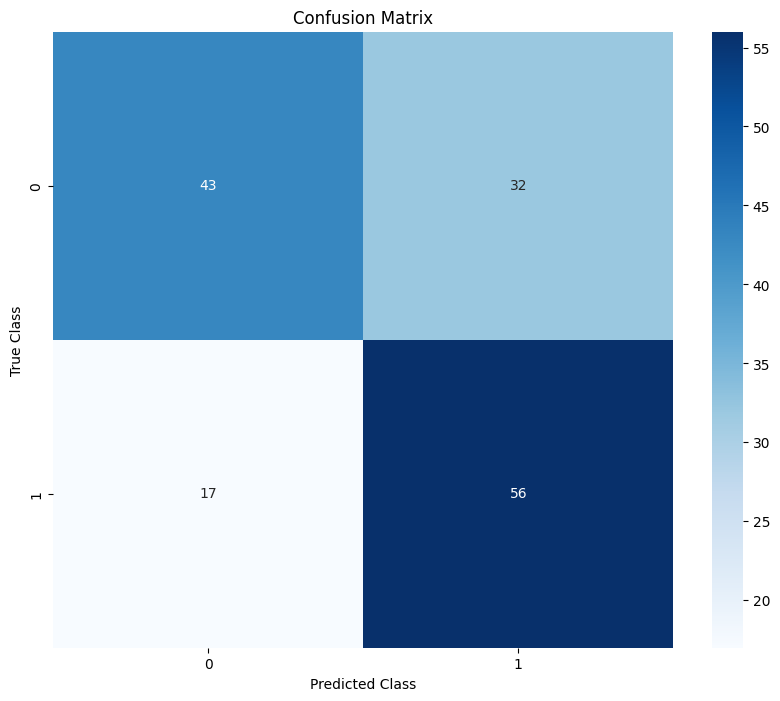

In [ ]:
cm = confusion_matrix(generator_test.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

## DenseNet121 - Model 3

In [ ]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
input_shape = (299, 299)
batch_size = 16

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20
)

datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

generator_train = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

generator_val = datagen_val.flow_from_directory(
    directory=val_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

generator_test = datagen_test.flow_from_directory(
    directory=test_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 519 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
base_model = DenseNet121(include_top=False, input_shape=(299, 299, 3), weights='imagenet')

In [ ]:
conv_model = Model(inputs=base_model.input, outputs=base_model.output)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class DualAttention(Layer):
    def __init__(self, input_dim, **kwargs):
        super(DualAttention, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.query = Dense(input_dim)
        self.key = Dense(input_dim)
        self.value = Dense(input_dim)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value)

        return attention_output


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(conv_model)
model.add(DualAttention(input_dim=conv_model.output.shape[-1], name='dual_attention_layer'))  # Add DualAttention layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', name='output_layer'))

In [ ]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 9, 9, 1024)        7037504   
                                                                 
 dual_attention_layer (Dual  (None, 9, 9, 1024)        3148800   
 Attention)                                                      
                                                                 
 flatten_6 (Flatten)         (None, 82944)             0         
                                                                 
 dropout_11 (Dropout)        (None, 82944)             0         
                                                                 
 dense_41 (Dense)            (None, 512)               42467840  
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
steps_per_epoch = math.ceil(generator_train.samples / batch_size)
validation_steps = math.ceil(generator_val.samples / batch_size)

# Define ModelCheckpoint and EarlyStopping callbacks
checkpoint_dir = "/content/drive/MyDrive/newModelData2/DenseNet121_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

Checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'DenseNet121_model_epoch_{epoch:02d}.hdf5'),
    monitor="val_accuracy",
    save_best_only=False,
    save_weights_only=False,
    mode="auto"
)

EarlyStop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="auto"
)

# Train the model
epochs = 30  # Define the number of epochs
history = model.fit(
    generator_train,
    epochs=epochs,
    callbacks=[Checkpoint, EarlyStop],
    steps_per_epoch=steps_per_epoch,
    validation_data=generator_val,
    validation_steps=validation_steps
)


Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 12.0610 - accuracy: 0.5742

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 77s 602ms/step - loss: 12.0610 - accuracy: 0.5742 - val_loss: 10.8100 - val_accuracy: 0.6933
Epoch 2/30
33/33 [==============================] - 18s 549ms/step - loss: 10.7026 - accuracy: 0.6069 - val_loss: 10.1614 - val_accuracy: 0.6667
Epoch 3/30
33/33 [==============================] - 18s 554ms/step - loss: 9.7968 - accuracy: 0.5819 - val_loss: 9.4920 - val_accuracy: 0.6933
Epoch 4/30
33/33 [==============================] - 19s 561ms/step - loss: 9.1406 - accuracy: 0.6936 - val_loss: 8.9541 - val_accuracy: 0.6933
Epoch 5/30
33/33 [==============================] - 20s 561ms/step - loss: 8.7192 - accuracy: 0.6628 - val_loss: 8.5839 - val_accuracy: 0.7067
Epoch 6/30
33/33 [==============================] - 19s 548ms/step - loss: 8.3348 - accuracy: 0.7052 - val_loss: 8.2299 - val_accuracy: 0.6667
Epoch 7/30
33/33 [==============================] - 19s 559ms/step - loss: 7.9800 - accuracy: 0.7303 - val_loss: 7.8839 - val_accuracy: 0.7467
Epoch 

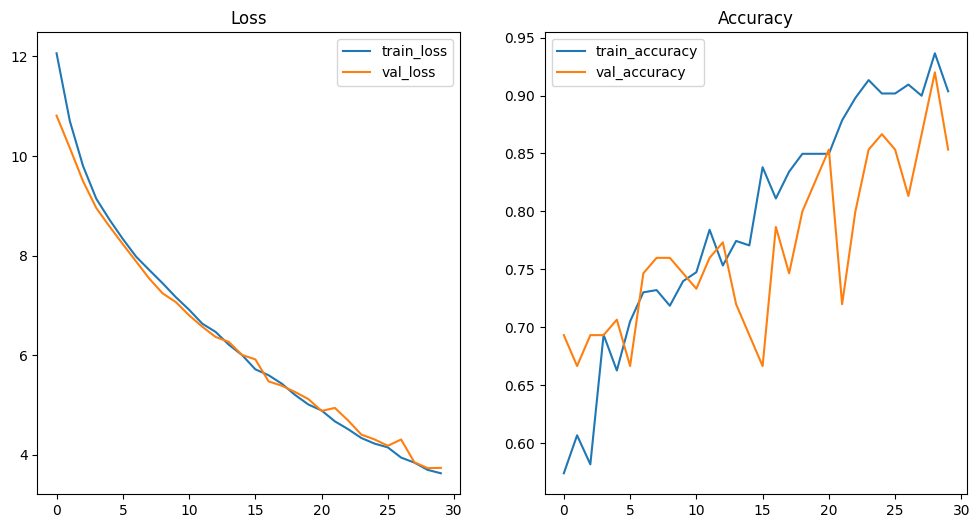

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/newModelData2/DenseNet121_checkpoints/final_efficientnet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/newModelData2/DenseNet121_checkpoints/final_efficientnet_model')


In [ ]:
model_path = "/content/drive/MyDrive/newModelData2/DenseNet121_checkpoints/final_efficientnet_model.h5"

In [ ]:
# new_model=tf.keras.models.load_model(model_path)
from tensorflow.keras.models import load_model

# Load the model with the custom layer
# model_path = "/content/drive/MyDrive/newModelData2/checkpoints/final_model_with_attention.h5"
new_model = load_model(model_path, custom_objects={'DualAttention': DualAttention})

In [ ]:
Y_pred = new_model.predict(generator_test)
y_pred = np.argmax(Y_pred, axis=1)

10/10 [==============================] - 3s 93ms/step


In [ ]:
class_labels = list(generator_test.class_indices.keys())

In [ ]:
print(classification_report(generator_test.classes, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        75
           1       0.89      0.74      0.81        73

    accuracy                           0.82       148
   macro avg       0.83      0.82      0.82       148
weighted avg       0.83      0.82      0.82       148



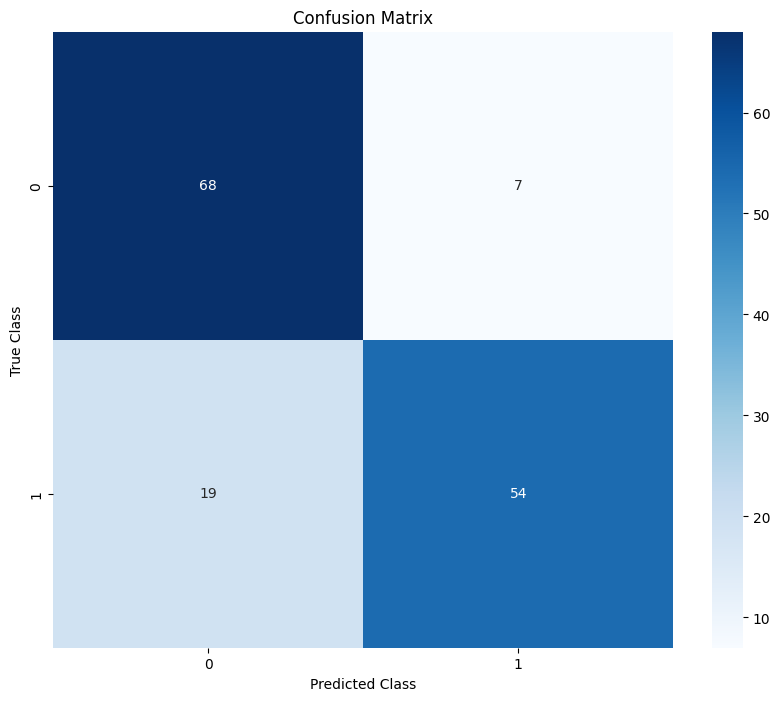

In [ ]:
cm = confusion_matrix(generator_test.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()